In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [2]:
import deepxde as dde 
import tensorflow as tf 

import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint

2023-10-07 10:38:56.025981: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-07 10:38:56.026036: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-07 10:38:56.026065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-07 10:38:56.034973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



# Spring and Mass System

In [3]:
# Masses
m1 = 1.0
m2 = 1.0 
# Spring constants
k1 = 5.0
k2 = 2.0
# Natural lengths
L1 = 0.5
L2 = 0.5
# friction coefficients
b1 = 0.1
b2 = 0.1

# Initial conditions
# d1_0 and d2_0 are the initial displacements, v1_0 and v2_0 are the initial velocities
d1_0 = 0.5
d2_0 = 3.25

v1_0 = 0.0
v2_0 = 0.0

# maximum time to simulate
t_max = 5

In [4]:
def pde(t, x):
    x1 = x[:, 0:1]
    x2 = x[:, 1:2]

    dx1_t = dde.grad.jacobian(x1, t)
    dx2_t = dde.grad.jacobian(x2, t)

    dx1_tt = dde.grad.hessian(x1, t, i=0, j=0)
    dx2_tt = dde.grad.hessian(x2, t, i=0, j=0)
    # dx1_tt = dde.grad.hessian(x, t, i=0, j=0, component=0)
    # dx2_tt = dde.grad.hessian(x, t, i=0, j=0, component=1)

    pde1 = m1*dx1_tt + b1*dx1_t + k1*(x1-L1) - k2*(x2-x1-L2)
    pde2 = m2*dx2_tt + b2*dx2_t + k2*(x2-x1-L2)
    
    return [pde1, pde2]

In [5]:
def boundary_init(t, on_boundary):
    return on_boundary and np.isclose(t[0], 0)

In [6]:
geom = dde.geometry.Interval(0, t_max)

init_d1 = dde.icbc.PointSetBC(np.array([0]), np.array([d1_0]).reshape(-1, 1), component=0)
init_d2 = dde.icbc.PointSetBC(np.array([0]), np.array([d2_0]).reshape(-1, 1), component=1)
init_v1 = dde.OperatorBC(geom, lambda t, x, _: dde.grad.jacobian(x[:, 0:1], t), boundary_init)
init_v2 = dde.OperatorBC(geom, lambda t, x, _: dde.grad.jacobian(x[:, 1:2], t), boundary_init)

data = dde.data.PDE(geom,
                    pde,
                    [init_d1, init_d2, init_v1, init_v2],
                    num_domain = 5000,
                    num_boundary = 200,
                    num_test = 1000)

2023-10-07 10:39:00.434229: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-07 10:39:00.435169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:82:00.0, compute capability: 7.0


In [7]:
layer_size = [1] + [20] * 3 + [2]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

In [8]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.004649 s



Training model...



/userhome/jeon_mg/miniforge3/envs/pinn/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2023-10-07 10:39:02.537087: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bfb9224640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-07 10:39:02.537141: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2023-10-07 10:39:02.556136: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-07 10:39:03.277963: I tensorflow/compiler/xl

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.16e+01, 1.26e-01, 2.50e-01, 1.06e+01, 1.47e-01, 1.00e-03]    [2.19e+01, 1.09e-01, 2.50e-01, 1.06e+01, 1.47e-01, 1.00e-03]    []  


2023-10-07 10:39:08.356033: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_64', 52 bytes spill stores, 52 bytes spill loads



1000      [1.19e-01, 2.62e-01, 1.67e-01, 1.16e-01, 7.36e-05, 7.07e-04]    [1.20e-01, 2.71e-01, 1.67e-01, 1.16e-01, 7.36e-05, 7.07e-04]    []  
2000      [8.97e-02, 4.33e-02, 1.27e-01, 2.05e-02, 6.79e-06, 7.89e-05]    [9.30e-02, 3.78e-02, 1.27e-01, 2.05e-02, 6.79e-06, 7.89e-05]    []  
3000      [7.91e-02, 3.28e-02, 6.77e-02, 9.32e-03, 4.73e-05, 1.71e-04]    [8.21e-02, 2.69e-02, 6.77e-02, 9.32e-03, 4.73e-05, 1.71e-04]    []  
4000      [7.19e-03, 3.78e-03, 4.35e-03, 5.38e-04, 6.13e-06, 1.42e-06]    [7.26e-03, 3.49e-03, 4.35e-03, 5.38e-04, 6.13e-06, 1.42e-06]    []  
5000      [6.75e-04, 1.19e-03, 1.23e-04, 1.71e-05, 2.28e-09, 2.13e-07]    [6.71e-04, 1.13e-03, 1.23e-04, 1.71e-05, 2.29e-09, 2.14e-07]    []  
6000      [4.31e-04, 5.60e-04, 1.13e-05, 1.11e-06, 5.66e-08, 1.91e-07]    [3.64e-04, 5.38e-04, 1.13e-05, 1.11e-06, 5.66e-08, 1.91e-07]    []  
7000      [3.05e-04, 3.54e-04, 2.24e-06, 2.90e-07, 5.03e-08, 1.42e-07]    [2.46e-04, 3.46e-04, 2.24e-06, 2.90e-07, 5.05e-08, 1.43e-07]    []  

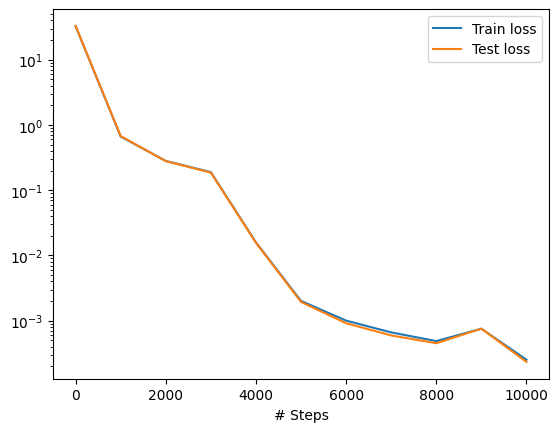

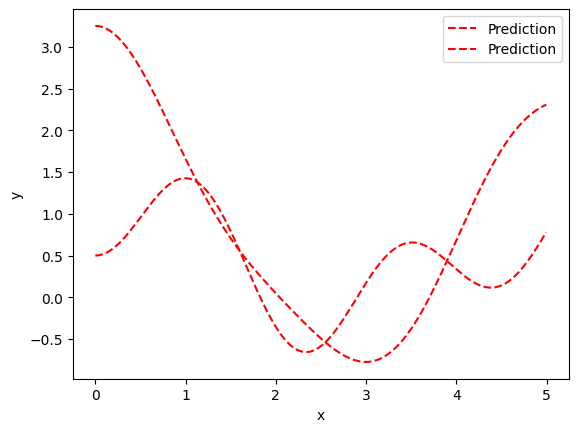

In [9]:
losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

In [10]:
def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w: vector of the state variables:
            w = [x1, y1, x2, y2]
        t: time
        p: vector of the parameters:
            p = [m1, m2, k1, k2, L1, L2, b1, b2]
    """
    x1, y1, x2, y2 = w 
    m1, m2, k1, k2, L1, L2, b1, b2 = p 

    # Create f = (x1', y1', x2', y2')
    f = [y1,
         (-b1*y1 - k1*(x1-L1) + k2*(x2-x1-L2))/m1,
         y2,
         (-b2*y2 - k2*(x2-x1-L2))/m2]
    return f 

In [11]:
# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-8
stoptime = t_max 
numpoints = 150
t = geom.uniform_points(5000, boundary=True)

p = [m1, m2, k1, k2, L1, L2, b1, b2]
w0 = [d1_0, v1_0, d2_0, v2_0]

In [12]:
t.shape

(5000, 1)

In [13]:
t[:, 0].shape

(5000,)

In [14]:
t.squeeze().shape

(5000,)

In [15]:
wsol = odeint(vectorfield, w0, t.squeeze(), args=(p,), atol=abserr, rtol=relerr)

In [16]:
wsol.shape

(5000, 4)

In [17]:
wsol

array([[ 0.5       ,  0.        ,  3.25      ,  0.        ],
       [ 0.50000225,  0.00450067,  3.24999775, -0.00450067],
       [ 0.500009  ,  0.00900084,  3.249991  , -0.00900087],
       ...,
       [ 0.78527645,  1.81380412,  2.30966681,  0.48164215],
       [ 0.78709034,  1.81423922,  2.31014737,  0.47954679],
       [ 0.78890553,  1.81466274,  2.31062606,  0.47745332]])

In [18]:
wsol[:, 0]

array([0.5       , 0.50000225, 0.500009  , ..., 0.78527645, 0.78709034,
       0.78890553])

In [19]:
wsol[:, 2]

array([3.25      , 3.24999775, 3.249991  , ..., 2.30966681, 2.31014737,
       2.31062606])

In [20]:
result = model.predict(t)
result.shape

(5000, 2)

In [21]:
result

array([[0.5004938 , 3.249885  ],
       [0.50049615, 3.2498832 ],
       [0.5005031 , 3.2498767 ],
       ...,
       [0.78472143, 2.308796  ],
       [0.7865306 , 2.3092768 ],
       [0.78834224, 2.3097558 ]], dtype=float32)

In [22]:
result[:, 0]

array([0.5004938 , 0.50049615, 0.5005031 , ..., 0.78472143, 0.7865306 ,
       0.78834224], dtype=float32)

In [23]:
result[:, 1]

array([3.249885 , 3.2498832, 3.2498767, ..., 2.308796 , 2.3092768,
       2.3097558], dtype=float32)

In [24]:
usol1 = np.array(result[:, 0])
usol2 = np.array(result[:, 1])

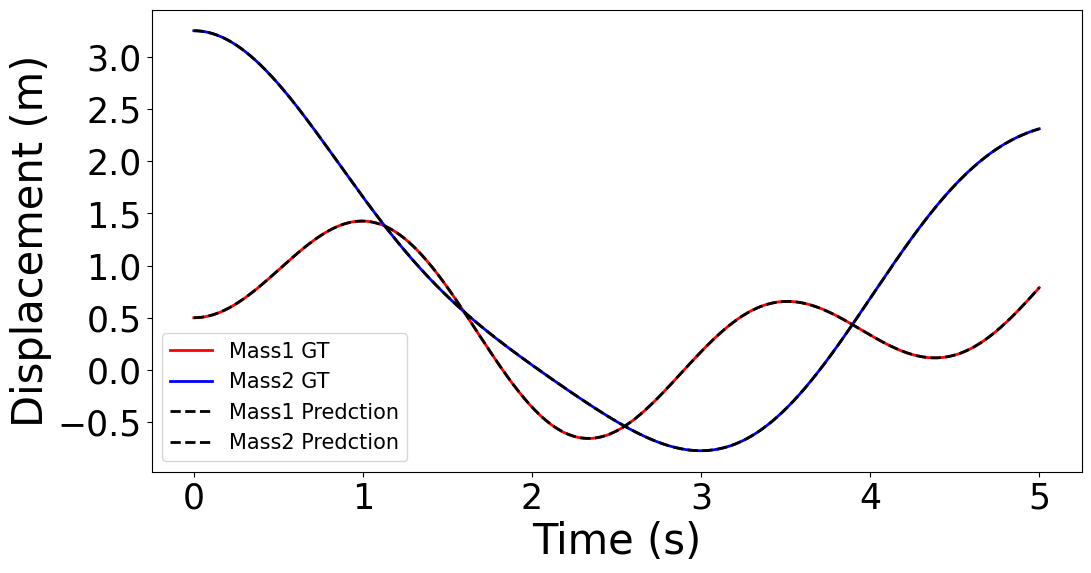

In [25]:
lw = 2
plt.figure(figsize=(12, 6))

plt.plot(t, wsol[:, 0], alpha=1, label='Mass1 GT', c='r', lw=lw)
plt.plot(t, wsol[:, 2], alpha=1, label='Mass2 GT', c='b', lw=lw)

plt.plot(t, usol1, alpha=1, label='Mass1 Predction', linestyle='dashed', c='k', lw=lw)
plt.plot(t, usol2, alpha=1, label='Mass2 Predction', linestyle='dashed', c='k', lw=lw)

plt.legend(fontsize=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Time (s)', fontsize=30)
plt.ylabel('Displacement (m)', fontsize=30)
plt.show()